In [166]:
import random
from dataclasses import dataclass, field
from enum import Enum
from typing import List, Tuple, Optional
from datetime import datetime, timedelta
import random 
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from bokeh.plotting import show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.io import push_notebook, reset_output, output_notebook
from uuid import uuid4

In [167]:
def get_random_value(loc=10, scale=10):
    return max(1, np.random.normal(loc=loc, scale=scale))

In [168]:
@dataclass
class Clock:
    diff: timedelta = timedelta(0)
    
    def get_now(self):
        return datetime.now() + self.diff

In [169]:
class NoUniteAvailable(Exception):
    pass

In [203]:
class Status(str, Enum):
    AVAILABLE = "AVAILABLE"
    BUSY = "BUSY"

    
class MissionType(str, Enum):
    AVP = "AVP"
    
clock = Clock()

@dataclass
class Mission:
    type: MissionType = MissionType.AVP
    started_at: datetime = field(default_factory= lambda: clock.get_now())
    coordinates: Tuple[float, float] = (None, None)
        
    rand_value = get_random_value(3, 1) # Mettre en place la probabilité en fonction du mean et std du mission type

    @property
    def time_to_complete(self):
        return  timedelta(seconds=self.rand_value)
    
    @property
    def etc(self) -> timedelta :
        diff = self.time_diff
        return diff if diff > timedelta(0) else 0
    
    @property
    def time_diff(self):
        return self.started_at + self.time_to_complete - clock.get_now() 
    
    def finished(self) -> bool:
        if self.etc == 0 :
            return True
        else:
            return False
        

@dataclass
class Unite:
    mission: Mission = None
    rand_value = get_random_value(4, 2)
    
    @property
    def time_to_complete(self):
        return timedelta(seconds=self.rand_value) # Ajouter temps de transit entre la caserne de ratachement et la mission
    
    @property
    def status(self) -> Status:
        if self.eta > timedelta(0):
            return Status.BUSY
        else:
            return Status.AVAILABLE

        
    @property
    def eta(self) -> timedelta:
        if self.mission:
            diff = self.mission.time_diff + self.time_to_complete
            if diff > timedelta(0):
                return diff
        return timedelta(0)
    
    @property
    def is_available(self) -> bool:
        return self.status is Status.AVAILABLE 
        
        
    def set_mission(self, mission: Mission):
        self.mission = mission
        
    def __repr__(self):
        return f"Unite {self.status} ETA : {self.eta}"


@dataclass
class Caserne:
    name: str = field(default_factory=lambda x: f"Caserne {uuid4()}")
    coordinates: Tuple[float, float]  = (3.14, 3.14)
    unites: List[Unite] = field(default_factory=list)
        
    def __post_init__(self):
        self.setup()
        
    def setup(self, N=10):
        self.unites = [Unite() for _ in range(N)]
        
    @property
    def available_unites(self) -> List[Unite]:
        return [unite for unite in self.unites if unite.is_available]    
            
    def assign_mission(self, mission: Mission):
        if self.available_unites:
            self.available_unites[0].set_mission(mission)
        else:
            raise NoUniteAvailable
            
    @property
    def availability(self) -> float:
        return len(self.available_unites)/len(self.unites)
    
    @property
    def has_available_unite(self) -> bool:
        return len(self.available_unites) > 0
        
        
    def __repr__(self):
        return f"""NOM : {self.name}\n{' # '.join([str(u) for u in self.unites])}
        """
            
@dataclass
class UniteFonctionnelle:
    name: str
    size: int = 6
    polygon: Tuple[Tuple[float, float]]  = ((3.14, 3.14), (3.14, 3.14))
    casernes: List[Caserne] = field(default_factory=list)
        
    def __post_init__(self):
        self.setup()
    
    def setup(self, coordinates: Optional[List] = None, names: Optional[List] = None):
        if not coordinates:
            coordinates = [(int(c / self.size), c % self.size) for c in range(self.size**2)]
        if not names: 
            names = [f"Caserne {i+1}" for i in range(self.size**2)]
        self.casernes = [Caserne(coordinates=coordinates[c], name=names[c]) for c in range(self.size**2)]
        for caserne in self.casernes:
            caserne.setup()
        
    def assign_mission(self, mission: Mission) -> Caserne:
        caserne = random.choice(self.casernes)
        if caserne.has_available_unite:
            caserne.assign_mission(mission)
        return caserne

    @property
    def matrix(self) -> List[List]:
        matrix = [[0 for i in range(self.size)] for _ in range(self.size)]
        for c, cas in enumerate(self.casernes):
            i,j = int(c / self.size), c % self.size
            matrix[i][j] = cas.availability
        return matrix
            
    def __repr__(self):
        return f"NOM : {self.name}\n{ ' # '.join([str(c.name) for c in self.casernes])}"

In [204]:
uf = UniteFonctionnelle("cgo-77")

In [205]:
uf

NOM : cgo-77
Caserne 1 # Caserne 2 # Caserne 3 # Caserne 4 # Caserne 5 # Caserne 6 # Caserne 7 # Caserne 8 # Caserne 9 # Caserne 10 # Caserne 11 # Caserne 12 # Caserne 13 # Caserne 14 # Caserne 15 # Caserne 16 # Caserne 17 # Caserne 18 # Caserne 19 # Caserne 20 # Caserne 21 # Caserne 22 # Caserne 23 # Caserne 24 # Caserne 25 # Caserne 26 # Caserne 27 # Caserne 28 # Caserne 29 # Caserne 30 # Caserne 31 # Caserne 32 # Caserne 33 # Caserne 34 # Caserne 35 # Caserne 36

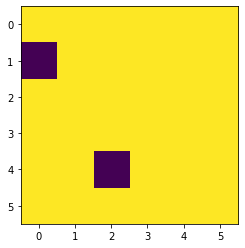

In [172]:


fig, ax = plt.subplots();
im = ax.imshow(uf.matrix, animated=True);

def animate(i):
    
    #print(counter)
    for _ in range(2):
        m = Mission()
        uf.assign_mission(m)
    _ = ax.imshow(uf.matrix, animated=True);
    return im,

ani = FuncAnimation(fig, animate, frames=100, interval=20, blit=True);

In [7]:
HTML(ani.to_html5_video())

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '432x288', '-pix_fmt', 'rgba', '-r', '50.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/var/folders/x4/1hlmtvlj5q562t6xsngjlgqw0000gn/T/tmp162uh790/temp.m4v']' returned non-zero exit status 255.

# Bokeh test stream

In [149]:
from sklearn.preprocessing import normalize
from collections import defaultdict


def uf_matrix_to_bokeh_data(uf: UniteFonctionnelle):
    matrix = list(uf.matrix)
    d = defaultdict(list)
    for r, row in enumerate(matrix):
        for c, col in enumerate(row):
            d["x"].append(r)
            d["y"].append(c)
            d["size"].append(col)
            
    #d["size"] = normalize(np.asarray(d["size"]).reshape(1, -1), norm='max', axis=0)[0,:]/10
    #d["size"] = normalize(np.random.normal(10, 5, size=(6**2)).reshape(1, -1), norm='max',)[0,:]/10
    return d

In [150]:
from bokeh.plotting import curdoc 
output_notebook()
uf = UniteFonctionnelle("cgo-77")

source = ColumnDataSource(data=dict(x=[], y=[], size=[]))
new_data = uf_matrix_to_bokeh_data(uf)

Loading BokehJS ...

In [151]:
import time

In [152]:
p = figure()
bokeh_doc.add_root(p )
p.circle(x='x', y='y', radius='size', source=source)
handle = show(p, notebook_handle=True)
def update(uf):
    for _ in range(50):
        m = Mission()
        uf.assign_mission(m)
    new_data = uf_matrix_to_bokeh_data(uf)
    source.stream(new_data, 16)
    push_notebook(handle=handle)
    return new_data
    
while True:
    t = update(uf)
    print(f"UF size :{t['size']}")
    time.sleep(0.5)


UF size :[1.0, 0.9, 0.8, 0.9, 0.9, 0.9, 1.0, 0.7, 0.9, 0.9, 0.8, 0.9, 0.9, 0.7, 0.9, 0.8, 1.0, 0.9, 0.9, 1.0, 0.5, 0.8, 0.8, 0.8, 0.8, 0.9, 1.0, 0.7, 0.9, 0.8, 0.9, 0.9, 0.8, 0.8, 1.0, 0.9]
UF size :[0.9, 0.9, 0.7, 0.5, 0.6, 0.9, 0.8, 0.2, 0.8, 0.7, 0.7, 0.8, 0.9, 0.4, 0.9, 0.7, 0.9, 0.8, 0.8, 0.5, 0.3, 0.7, 0.8, 0.5, 0.6, 0.9, 0.9, 0.5, 0.8, 0.8, 0.9, 0.8, 0.8, 0.7, 0.8, 0.8]
UF size :[0.7, 0.8, 0.4, 0.3, 0.5, 0.8, 0.6, 0.1, 0.7, 0.7, 0.7, 0.8, 0.7, 0.3, 0.6, 0.7, 0.9, 0.7, 0.8, 0.5, 0.1, 0.7, 0.7, 0.4, 0.5, 0.8, 0.8, 0.1, 0.5, 0.4, 0.9, 0.6, 0.4, 0.6, 0.8, 0.4]
UF size :[0.7, 0.7, 0.2, 0.3, 0.5, 0.6, 0.4, 0.1, 0.5, 0.3, 0.7, 0.8, 0.6, 0.1, 0.3, 0.6, 0.9, 0.7, 0.8, 0.3, 0.0, 0.4, 0.5, 0.4, 0.4, 0.4, 0.6, 0.1, 0.4, 0.2, 0.5, 0.4, 0.4, 0.5, 0.6, 0.1]
UF size :[0.7, 0.6, 0.2, 0.1, 0.2, 0.5, 0.3, 0.1, 0.4, 0.1, 0.6, 0.8, 0.5, 0.0, 0.3, 0.3, 0.7, 0.5, 0.7, 0.1, 0.0, 0.3, 0.5, 0.1, 0.0, 0.1, 0.4, 0.0, 0.4, 0.2, 0.4, 0.4, 0.1, 0.5, 0.3, 0.0]
UF size :[0.5, 0.6, 0.1, 0.0, 0.0, 0.3, 0.1, 0.0, 

UF size :[0.1, 0.4, 0.0, 0.1, 0.0, 0.2, 0.2, 0.1, 0.6, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.2, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.2, 0.3, 0.0, 0.2, 0.0, 0.3, 0.0, 0.0, 0.0]
UF size :[0.3, 0.5, 0.1, 0.1, 0.1, 0.0, 0.4, 0.0, 0.3, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.1, 0.0, 0.2, 0.0, 0.1, 0.0, 0.0, 0.3, 0.1, 0.3, 0.3, 0.0, 0.3, 0.0, 0.3, 0.0, 0.0, 0.0]
UF size :[0.2, 0.3, 0.0, 0.1, 0.4, 0.1, 0.4, 0.2, 0.2, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.1, 0.0, 0.2, 0.0, 0.0, 0.3, 0.0, 0.3, 0.2, 0.0, 0.2, 0.3, 0.3, 0.0, 0.0, 0.0]
UF size :[0.1, 0.2, 0.0, 0.1, 0.4, 0.1, 0.4, 0.2, 0.2, 0.0, 0.0, 0.1, 0.0, 0.2, 0.0, 0.2, 0.1, 0.0, 0.0, 0.1, 0.1, 0.0, 0.1, 0.0, 0.1, 0.4, 0.0, 0.3, 0.1, 0.0, 0.4, 0.0, 0.2, 0.1, 0.0, 0.0]
UF size :[0.1, 0.1, 0.2, 0.3, 0.4, 0.0, 0.5, 0.1, 0.3, 0.1, 0.0, 0.3, 0.0, 0.1, 0.0, 0.3, 0.0, 0.0, 0.0, 0.1, 0.2, 0.0, 0.2, 0.0, 0.2, 0.2, 0.0, 0.3, 0.0, 0.0, 0.6, 0.0, 0.1, 0.0, 0.0, 0.0]
UF size :[0.0, 0.0, 0.3, 0.3, 0.5, 0.0, 0.4, 0.3, 

UF size :[0.0, 0.0, 0.1, 0.5, 0.2, 0.0, 0.5, 0.0, 0.4, 0.2, 0.0, 0.1, 0.5, 0.0, 0.0, 0.0, 0.1, 0.2, 0.1, 0.1, 0.3, 0.0, 0.0, 0.3, 0.2, 0.0, 0.1, 0.1, 0.0, 0.4, 0.1, 0.2, 0.0, 0.0, 0.3, 0.0]
UF size :[0.2, 0.2, 0.0, 0.3, 0.1, 0.0, 0.4, 0.0, 0.1, 0.0, 0.2, 0.1, 0.3, 0.0, 0.0, 0.2, 0.1, 0.4, 0.0, 0.0, 0.2, 0.0, 0.0, 0.3, 0.2, 0.0, 0.0, 0.1, 0.0, 0.5, 0.1, 0.3, 0.1, 0.0, 0.3, 0.0]
UF size :[0.1, 0.3, 0.0, 0.0, 0.0, 0.0, 0.3, 0.0, 0.0, 0.0, 0.1, 0.0, 0.4, 0.2, 0.0, 0.3, 0.2, 0.3, 0.0, 0.0, 0.3, 0.2, 0.1, 0.4, 0.2, 0.0, 0.0, 0.2, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.4, 0.0]
UF size :[0.0, 0.1, 0.0, 0.0, 0.1, 0.0, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 0.1, 0.2, 0.0, 0.4, 0.3, 0.3, 0.0, 0.0, 0.3, 0.1, 0.2, 0.4, 0.1, 0.0, 0.0, 0.1, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.4, 0.0]
UF size :[0.0, 0.1, 0.3, 0.1, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.3, 0.0, 0.3, 0.2, 0.2, 0.0, 0.0, 0.4, 0.3, 0.1, 0.4, 0.1, 0.0, 0.1, 0.3, 0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
UF size :[0.1, 0.2, 0.4, 0.2, 0.0, 0.0, 0.0, 0.0, 

UF size :[0.2, 0.0, 0.0, 0.0, 0.2, 0.1, 0.3, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.1, 0.3, 0.0, 0.0, 0.4, 0.3, 0.1, 0.0, 0.2, 0.0, 0.0, 0.3, 0.2, 0.2, 0.3, 0.4, 0.1, 0.4, 0.0, 0.0, 0.3, 0.0, 0.0]
UF size :[0.1, 0.3, 0.3, 0.0, 0.2, 0.2, 0.1, 0.0, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 0.3, 0.0, 0.0, 0.3, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.5, 0.1, 0.0, 0.0, 0.0, 0.4, 0.0, 0.0]
UF size :[0.2, 0.3, 0.3, 0.1, 0.2, 0.0, 0.1, 0.0, 0.0, 0.1, 0.2, 0.0, 0.2, 0.0, 0.4, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.1, 0.3, 0.1, 0.2, 0.5, 0.2, 0.0, 0.0, 0.0, 0.3, 0.0, 0.0]
UF size :[0.0, 0.4, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.1, 0.0, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.0, 0.4, 0.3, 0.0, 0.3, 0.4, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0]
UF size :[0.1, 0.1, 0.2, 0.2, 0.3, 0.1, 0.0, 0.1, 0.0, 0.4, 0.0, 0.1, 0.1, 0.0, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.4, 0.1, 0.1, 0.6, 0.4, 0.0, 0.4, 0.7, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0]
UF size :[0.0, 0.0, 0.2, 0.3, 0.3, 0.0, 0.2, 0.0, 

UF size :[0.0, 0.2, 0.0, 0.0, 0.1, 0.3, 0.1, 0.2, 0.1, 0.4, 0.0, 0.1, 0.0, 0.0, 0.0, 0.6, 0.0, 0.0, 0.0, 0.3, 0.0, 0.0, 0.4, 0.0, 0.0, 0.3, 0.1, 0.1, 0.0, 0.0, 0.0, 0.2, 0.3, 0.2, 0.0, 0.2]
UF size :[0.1, 0.2, 0.0, 0.0, 0.4, 0.1, 0.1, 0.3, 0.1, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.4, 0.0, 0.0, 0.3, 0.3, 0.0, 0.1, 0.1, 0.0, 0.1, 0.3, 0.1, 0.1, 0.1]
UF size :[0.0, 0.1, 0.0, 0.0, 0.4, 0.0, 0.1, 0.3, 0.0, 0.4, 0.1, 0.2, 0.0, 0.0, 0.1, 0.2, 0.0, 0.0, 0.0, 0.1, 0.2, 0.0, 0.5, 0.0, 0.0, 0.2, 0.4, 0.0, 0.1, 0.0, 0.2, 0.2, 0.3, 0.1, 0.3, 0.0]
UF size :[0.0, 0.1, 0.0, 0.2, 0.2, 0.0, 0.2, 0.1, 0.3, 0.4, 0.2, 0.3, 0.0, 0.0, 0.2, 0.1, 0.0, 0.1, 0.0, 0.0, 0.1, 0.1, 0.4, 0.1, 0.0, 0.1, 0.3, 0.0, 0.4, 0.0, 0.1, 0.1, 0.4, 0.0, 0.2, 0.0]
UF size :[0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.4, 0.4, 0.3, 0.2, 0.0, 0.0, 0.3, 0.1, 0.2, 0.2, 0.1, 0.0, 0.1, 0.0, 0.3, 0.0, 0.0, 0.0, 0.3, 0.1, 0.3, 0.0, 0.0, 0.1, 0.3, 0.0, 0.1, 0.1]
UF size :[0.1, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 

UF size :[0.5, 0.2, 0.0, 0.0, 0.1, 0.3, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.1, 0.2, 0.3, 0.1, 0.4, 0.3, 0.0, 0.0, 0.1, 0.0, 0.0, 0.2, 0.0, 0.1, 0.0, 0.0, 0.5, 0.0, 0.5, 0.2, 0.0, 0.1, 0.2, 0.0]
UF size :[0.5, 0.2, 0.2, 0.0, 0.3, 0.2, 0.0, 0.0, 0.2, 0.1, 0.2, 0.0, 0.0, 0.0, 0.3, 0.1, 0.7, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.0, 0.0, 0.0, 0.0, 0.3, 0.0, 0.3, 0.3, 0.3, 0.0, 0.3, 0.0]
UF size :[0.2, 0.4, 0.1, 0.0, 0.3, 0.2, 0.0, 0.2, 0.2, 0.0, 0.3, 0.1, 0.2, 0.0, 0.0, 0.0, 0.6, 0.2, 0.0, 0.0, 0.2, 0.0, 0.1, 0.2, 0.1, 0.2, 0.0, 0.0, 0.3, 0.1, 0.4, 0.0, 0.3, 0.0, 0.3, 0.0]
UF size :[0.4, 0.3, 0.2, 0.0, 0.2, 0.2, 0.1, 0.0, 0.3, 0.0, 0.2, 0.1, 0.2, 0.0, 0.0, 0.1, 0.4, 0.5, 0.0, 0.0, 0.4, 0.0, 0.3, 0.2, 0.1, 0.1, 0.1, 0.0, 0.2, 0.0, 0.2, 0.0, 0.3, 0.0, 0.1, 0.0]
UF size :[0.4, 0.5, 0.2, 0.0, 0.2, 0.0, 0.0, 0.0, 0.3, 0.0, 0.2, 0.0, 0.2, 0.2, 0.0, 0.0, 0.5, 0.4, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 0.3, 0.2, 0.1, 0.0, 0.0, 0.1]
UF size :[0.4, 0.6, 0.1, 0.0, 0.2, 0.0, 0.1, 0.0, 

KeyboardInterrupt: 

In [194]:
!pip install bokeh